## NLP for "Classifying Clinically Actionable Genetic Mutations: NIPS 2017 Competition"

This Notebook outlines the pipeline for classifiying Cancer Genome Data Based on data from the Memorial Sloan Kettering Cancer Center.

In [1]:
from sklearn import preprocessing, pipeline, feature_extraction, decomposition, model_selection, metrics, cross_validation, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import normalize, Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb

import datetime

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../input/training_variants')
test = pd.read_csv('../input/test_variants')
trainx = pd.read_csv('../input/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
testx = pd.read_csv('../input/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

train = pd.merge(train, trainx, how='left', on='ID').fillna('')
y = train['Class'].values
train = train.drop(['Class'], axis=1)

test = pd.merge(test, testx, how='left', on='ID').fillna('')
pid = test['ID'].values

In [3]:
train.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [4]:
y

array([1, 2, 2, ..., 1, 4, 4])

In [5]:
test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [6]:
pid

array([   0,    1,    2, ..., 5665, 5666, 5667])

In [7]:
df_all = pd.concat((train, test), axis=0, ignore_index=True)
df_all['Gene_Share'] = df_all.apply(lambda r: sum([1 for w in r['Gene'].split(' ') if w in r['Text'].split(' ')]), axis=1)
df_all['Variation_Share'] = df_all.apply(lambda r: sum([1 for w in r['Variation'].split(' ') if w in r['Text'].split(' ')]), axis=1)

In [9]:
df_all.head()

,ID,Gene,Variation,Text,Gene_Share,Variation_Share
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,1,1
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,1,1
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,1,1
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,1,1


In [10]:
gen_var_lst = sorted(list(train.Gene.unique()) + list(train.Variation.unique()))
print(len(gen_var_lst))

3260


In [11]:
gen_var_lst = [x for x in gen_var_lst if len(x.split(' '))==1]
print(len(gen_var_lst))
i_ = 0

3091


This Code block was used for testing the above section, but is not used in the full version of this Notebook:
```python
for gen_var_lst_itm in gen_var_lst:
     if i_ % 100 == 0: print(i_)
     df_all['GV_'+str(gen_var_lst_itm)] = df_all['Text'].map(lambda x: str(x).count(str(gen_var_lst_itm)))
     i_ += 1
```

In [12]:
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        if c in ['Gene','Variation']:
            lbl = preprocessing.LabelEncoder()
            df_all[c+'_lbl_enc'] = lbl.fit_transform(df_all[c].values)  
            df_all[c+'_len'] = df_all[c].map(lambda x: len(str(x)))
            df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' ')))
        elif c != 'Text':
            lbl = preprocessing.LabelEncoder()
            df_all[c] = lbl.fit_transform(df_all[c].values)
        if c=='Text': 
            df_all[c+'_len'] = df_all[c].map(lambda x: len(str(x)))
            df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' '))) 

train = df_all.iloc[:len(train)]
test = df_all.iloc[len(train):]

In [13]:
train.head()

,ID,Gene,Variation,Text,Gene_Share,Variation_Share,Gene_lbl_enc,Gene_len,Gene_words,Variation_lbl_enc,Variation_len,Variation_words,Text_len,Text_words
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1,1,447,6,1,7654,20,2,39672,6105
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,1,1,216,3,1,8255,5,1,36691,5783
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,1,1,216,3,1,5191,5,1,36691,5783
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,1,1,216,3,1,4572,5,1,36238,5625
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,1,1,216,3,1,3958,5,1,41308,6248


In [14]:
test.head()

,ID,Gene,Variation,Text,Gene_Share,Variation_Share,Gene_lbl_enc,Gene_len,Gene_words,Variation_lbl_enc,Variation_len,Variation_words,Text_len,Text_words
3321,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...,0,1,28,5,1,6404,5,1,49829,7495
3322,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...,0,1,852,5,1,5005,5,1,31326,4762
3323,2,PAH,L333F,Vascular endothelial growth factor receptor (V...,0,1,950,3,1,3915,5,1,75282,11191
3324,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...,0,1,657,4,1,85,5,1,53996,8439
3325,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...,0,1,1376,7,1,2780,4,1,76967,11226


In [15]:
train.shape

(3321, 14)

In [16]:
test.shape

(5668, 14)

In [19]:
class cust_regression_vals(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.drop(['Gene', 'Variation','ID','Text'],axis=1).values
        return x

class cust_txt_col(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)

In [20]:
print('Pipeline...')
fp = pipeline.Pipeline([
    ('union', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            ('standard', cust_regression_vals()),
            ('pi1', pipeline.Pipeline([('Gene', cust_txt_col('Gene')), 
                                       ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                                       ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            ('pi2', pipeline.Pipeline([('Variation', cust_txt_col('Variation')), 
                                       ('count_Variation', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                                       ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            #('pi3', pipeline.Pipeline([('Text', cust_txt_col('Text')), ('tfidf_Text', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2))), ('tsvd3', decomposition.TruncatedSVD(n_components=50, n_iter=25, random_state=12))]))
        ])
    )])

train = fp.fit_transform(train); print(train.shape)
test = fp.transform(test); print(test.shape)

Pipeline...
(3321, 50)
(5668, 50)


In [21]:
print('Pipeline...')
fp = pipeline.Pipeline([
    ('union', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            ('standard', cust_regression_vals()),
            ('pi1', pipeline.Pipeline([('Gene', cust_txt_col('Gene')), 
                                       ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                                       ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            ('pi2', pipeline.Pipeline([('Variation', cust_txt_col('Variation')), 
                                       ('count_Variation', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                                       ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            #commented for Kaggle Limits
             ('pi3', pipeline.Pipeline([('Text', cust_txt_col('Text')), 
                                        ('hv', feature_extraction.text.HashingVectorizer(decode_error='ignore', n_features=2 ** 16, non_negative=True, ngram_range=(1, 3))),
                                        ('tfidf_Text', feature_extraction.text.TfidfTransformer()), 
                                        ('tsvd3', decomposition.TruncatedSVD(n_components=300, n_iter=25, random_state=12))]))
        ])
    )])

train = fp.fit_transform(train)
print (train.shape)

test_t = np.empty([0, train.shape[1]])
step = 200
for i in range(0, len(test), step):
    step_end = i+step
    step_end = step_end if step_end < len(test) else len(test)
    _test = fp.transform(test.iloc[i:step_end])
    test_t = np.vstack((test_t, _test))
test = test_t
print (test.shape)

Pipeline...


JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/conda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/opt/conda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f1dd26a6f60, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f1dd26a6f60, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 22, 4, 22, 11, 267881, tzinfo=datetime.timezone.utc), 'msg_id': '061736284F87465381C39B72467C415D', 'msg_type': 'execute_request', 'session': 'AE08415D97474BA2A32F156BD1F79383', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '061736284F87465381C39B72467C415D', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'AE08415D97474BA2A32F156BD1F79383']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 22, 4, 22, 11, 267881, tzinfo=datetime.timezone.utc), 'msg_id': '061736284F87465381C39B72467C415D', 'msg_type': 'execute_request', 'session': 'AE08415D97474BA2A32F156BD1F79383', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '061736284F87465381C39B72467C415D', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'AE08415D97474BA2A32F156BD1F79383'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 22, 4, 22, 11, 267881, tzinfo=datetime.timezone.utc), 'msg_id': '061736284F87465381C39B72467C415D', 'msg_type': 'execute_request', 'session': 'AE08415D97474BA2A32F156BD1F79383', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '061736284F87465381C39B72467C415D', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="print('Pipeline...')\nfp = pipeline.Pipeline([\n  ...(test_t, _test))\ntest = test_t\nprint (test.shape)", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-21-0d25f92c161c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f1d9c8fb828, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f1d9c904930, file "<ipython-input-21-0d25f92c161c>", line 21>
        result = <ExecutionResult object at 7f1d9c8fb828, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f1d9c904930, file "<ipython-input-21-0d25f92c161c>", line 21>, result=<ExecutionResult object at 7f1d9c8fb828, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f1d9c904930, file "<ipython-input-21-0d25f92c161c>", line 21>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'from sklearn import preprocessing, pipeline, fea...umpy as np\nimport xgboost as xgb\n\nimport datetime', "train = pd.read_csv('../input/training_variants'...eft', on='ID').fillna('')\npid = test['ID'].values", 'train.head()', 'y', 'test.head()', 'pid', "df_all = pd.concat((train, test), axis=0, ignore...plit(' ') if w in r['Text'].split(' ')]), axis=1)", 'df_all.head()', 'df_all.head()', 'gen_var_lst = sorted(list(train.Gene.unique()) +...rain.Variation.unique()))\nprint(len(gen_var_lst))', "gen_var_lst = [x for x in gen_var_lst if len(x.split(' '))==1]\nprint(len(gen_var_lst))\ni_ = 0", 'for c in df_all.columns:\n    if df_all[c].dtype ...iloc[:len(train)]\ntest = df_all.iloc[len(train):]', 'train.head()', 'test.head()', 'train.shape', 'test.shape', 'class cust_regression_vals(sklearn.base.BaseEsti...m(self, x):\n        return x[self.key].apply(str)', 'class cust_regression_vals(sklearn.base.BaseEsti...m(self, x):\n        return x[self.key].apply(str)', 'class cust_regression_vals(sklearn.base.BaseEsti...m(self, x):\n        return x[self.key].apply(str)', ...], 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {3:    ID    Gene             Variation  \
0   0  FA...cogenic mutations in the monomeric Casitas B...  , 4: array([1, 2, 2, ..., 1, 4, 4]), 5:    ID     Gene Variation                        ... Abstract Retinoblastoma is a pediatric retina..., 6: array([   0,    1,    2, ..., 5665, 5666, 5667]), 8:    ID    Gene             Variation  \
0   0  FA...    1  
3                1  
4                1  , 9:    ID    Gene             Variation  \
0   0  FA...    1  
3                1  
4                1  , 13:    ID    Gene             Variation  \
0   0  FA...       5                1     41308        6248  , 14:       ID     Gene Variation  \
3321   0    ACSL4...       4                1     76967       11226  , 15: (3321, 14), 16: (5668, 14)}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'from sklearn import preprocessing, pipeline, fea...umpy as np\nimport xgboost as xgb\n\nimport datetime', "train = pd.read_csv('../input/training_variants'...eft', on='ID').fillna('')\npid = test['ID'].values", 'train.head()', 'y', 'test.head()', 'pid', "df_all = pd.concat((train, test), axis=0, ignore...plit(' ') if w in r['Text'].split(' ')]), axis=1)", 'df_all.head()', 'df_all.head()', 'gen_var_lst = sorted(list(train.Gene.unique()) +...rain.Variation.unique()))\nprint(len(gen_var_lst))', "gen_var_lst = [x for x in gen_var_lst if len(x.split(' '))==1]\nprint(len(gen_var_lst))\ni_ = 0", 'for c in df_all.columns:\n    if df_all[c].dtype ...iloc[:len(train)]\ntest = df_all.iloc[len(train):]', 'train.head()', 'test.head()', 'train.shape', 'test.shape', 'class cust_regression_vals(sklearn.base.BaseEsti...m(self, x):\n        return x[self.key].apply(str)', 'class cust_regression_vals(sklearn.base.BaseEsti...m(self, x):\n        return x[self.key].apply(str)', 'class cust_regression_vals(sklearn.base.BaseEsti...m(self, x):\n        return x[self.key].apply(str)', ...], 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {3:    ID    Gene             Variation  \
0   0  FA...cogenic mutations in the monomeric Casitas B...  , 4: array([1, 2, 2, ..., 1, 4, 4]), 5:    ID     Gene Variation                        ... Abstract Retinoblastoma is a pediatric retina..., 6: array([   0,    1,    2, ..., 5665, 5666, 5667]), 8:    ID    Gene             Variation  \
0   0  FA...    1  
3                1  
4                1  , 9:    ID    Gene             Variation  \
0   0  FA...    1  
3                1  
4                1  , 13:    ID    Gene             Variation  \
0   0  FA...       5                1     41308        6248  , 14:       ID     Gene Variation  \
3321   0    ACSL4...       4                1     76967       11226  , 15: (3321, 14), 16: (5668, 14)}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/kaggle/working/<ipython-input-21-0d25f92c161c> in <module>()
     16                                         ('tfidf_Text', feature_extraction.text.TfidfTransformer()), 
     17                                         ('tsvd3', decomposition.TruncatedSVD(n_components=300, n_iter=25, random_state=12))]))
     18         ])
     19     )])
     20 
---> 21 train = fp.fit_transform(train)
     22 print (train.shape)
     23 
     24 test_t = np.empty([0, train.shape[1]])
     25 step = 200

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py in fit_transform(self=Pipeline(memory=None,
     steps=[('union', Feat...ol=0.0))]))],
       transformer_weights=None))]), X=array([[  1.00000000e+00,   1.00000000e+00,   4....833119e-01,   3.54115780e-01,   6.02832365e-02]]), y=None, **fit_params={})
    278             Transformed samples
    279         """
    280         last_step = self._final_estimator
    281         Xt, fit_params = self._fit(X, y, **fit_params)
    282         if hasattr(last_step, 'fit_transform'):
--> 283             return last_step.fit_transform(Xt, y, **fit_params)
        last_step.fit_transform = <bound method FeatureUnion.fit_transform of Feat... tol=0.0))]))],
       transformer_weights=None)>
        Xt = array([[  1.00000000e+00,   1.00000000e+00,   4....833119e-01,   3.54115780e-01,   6.02832365e-02]])
        y = None
        fit_params = {}
    284         elif last_step is None:
    285             return Xt
    286         else:
    287             return last_step.fit(Xt, y, **fit_params).transform(Xt)

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py in fit_transform(self=FeatureUnion(n_jobs=-1,
       transformer_list=..., tol=0.0))]))],
       transformer_weights=None), X=array([[  1.00000000e+00,   1.00000000e+00,   4....833119e-01,   3.54115780e-01,   6.02832365e-02]]), y=None, **fit_params={})
    734         """
    735         self._validate_transformers()
    736         result = Parallel(n_jobs=self.n_jobs)(
    737             delayed(_fit_transform_one)(trans, weight, X, y,
    738                                         **fit_params)
--> 739             for name, trans, weight in self._iter())
        self._iter = <bound method FeatureUnion._iter of FeatureUnion... tol=0.0))]))],
       transformer_weights=None)>
    740 
    741         if not result:
    742             # All transformers are None
    743             return np.zeros((X.shape[0], 0))

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object FeatureUnion.fit_transform.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Fri Dec 22 04:22:12 2017
PID: 175                                Python 3.6.3: /opt/conda/bin/python
...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_transform_one>, (cust_regression_vals(), None, memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]]), None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_transform_one>
        args = (cust_regression_vals(), None, memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]]), None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=cust_regression_vals(), weight=None, X=memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]]), y=None, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method TransformerMixin.fit_transform of cust_regression_vals()>
        X = memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]])
        y = None
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/opt/conda/lib/python3.6/site-packages/sklearn/base.py in fit_transform(self=cust_regression_vals(), X=memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]]), y=None, **fit_params={})
    512         """
    513         # non-optimized default implementation; override when a better
    514         # method is possible for a given clustering algorithm
    515         if y is None:
    516             # fit method of arity 1 (unsupervised transformation)
--> 517             return self.fit(X, **fit_params).transform(X)
        self.fit = <bound method cust_regression_vals.fit of cust_regression_vals()>
        X = memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]])
        fit_params.transform = undefined
    518         else:
    519             # fit method of arity 2 (supervised transformation)
    520             return self.fit(X, y, **fit_params).transform(X)
    521 

...........................................................................
/kaggle/working/<ipython-input-19-c88d051142dd> in transform(self=cust_regression_vals(), x=memmap([[  1.00000000e+00,   1.00000000e+00,   4...833119e-01,   3.54115780e-01,   6.02832365e-02]]))
      1 class cust_regression_vals(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
      2     def fit(self, x, y=None):
      3         return self
      4     def transform(self, x):
----> 5         x = x.drop(['Gene', 'Variation','ID','Text'],axis=1).values
      6         return x
      7 
      8 class cust_txt_col(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
      9     def __init__(self, key):
     10         self.key = key

AttributeError: 'memmap' object has no attribute 'drop'
___________________________________________________________________________

In [22]:
y = y - 1 #fix for zero bound array

In [23]:
denom = 0
fold = 5 
for i in range(fold):
    params = {
        'eta': 0.02,
        'max_depth': 6, 
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.15, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
    print(score1)
    #if score < 0.9:
    if denom != 0:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds += pred
    else:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds = pred.copy()
    denom += 1
    submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission['ID'] = pid
    submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = pid
submission.to_csv('submission_xgb.csv', index=False)

[0]	train-mlogloss:2.15782	valid-mlogloss:2.16479
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.24063	valid-mlogloss:1.47325
[100]	train-mlogloss:0.912934	valid-mlogloss:1.25467
[150]	train-mlogloss:0.734402	valid-mlogloss:1.1651
[200]	train-mlogloss:0.613828	valid-mlogloss:1.11797
[250]	train-mlogloss:0.532413	valid-mlogloss:1.09372
[300]	train-mlogloss:0.459742	valid-mlogloss:1.0782
[350]	train-mlogloss:0.40078	valid-mlogloss:1.07044
[400]	train-mlogloss:0.352744	valid-mlogloss:1.06854
[450]	train-mlogloss:0.31163	valid-mlogloss:1.06999
[500]	train-mlogloss:0.276759	valid-mlogloss:1.07347
Stopping. Best iteration:
[402]	train-mlogloss:0.35102	valid-mlogloss:1.06827

1.06826797168
[0]	train-mlogloss:2.15929	valid-mlogloss:2.16676
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't

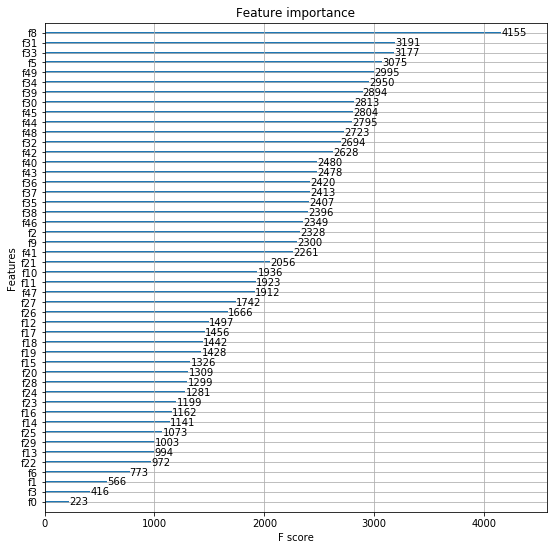

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (9.0, 9.0)
xgb.plot_importance(booster=model)
plt.show()

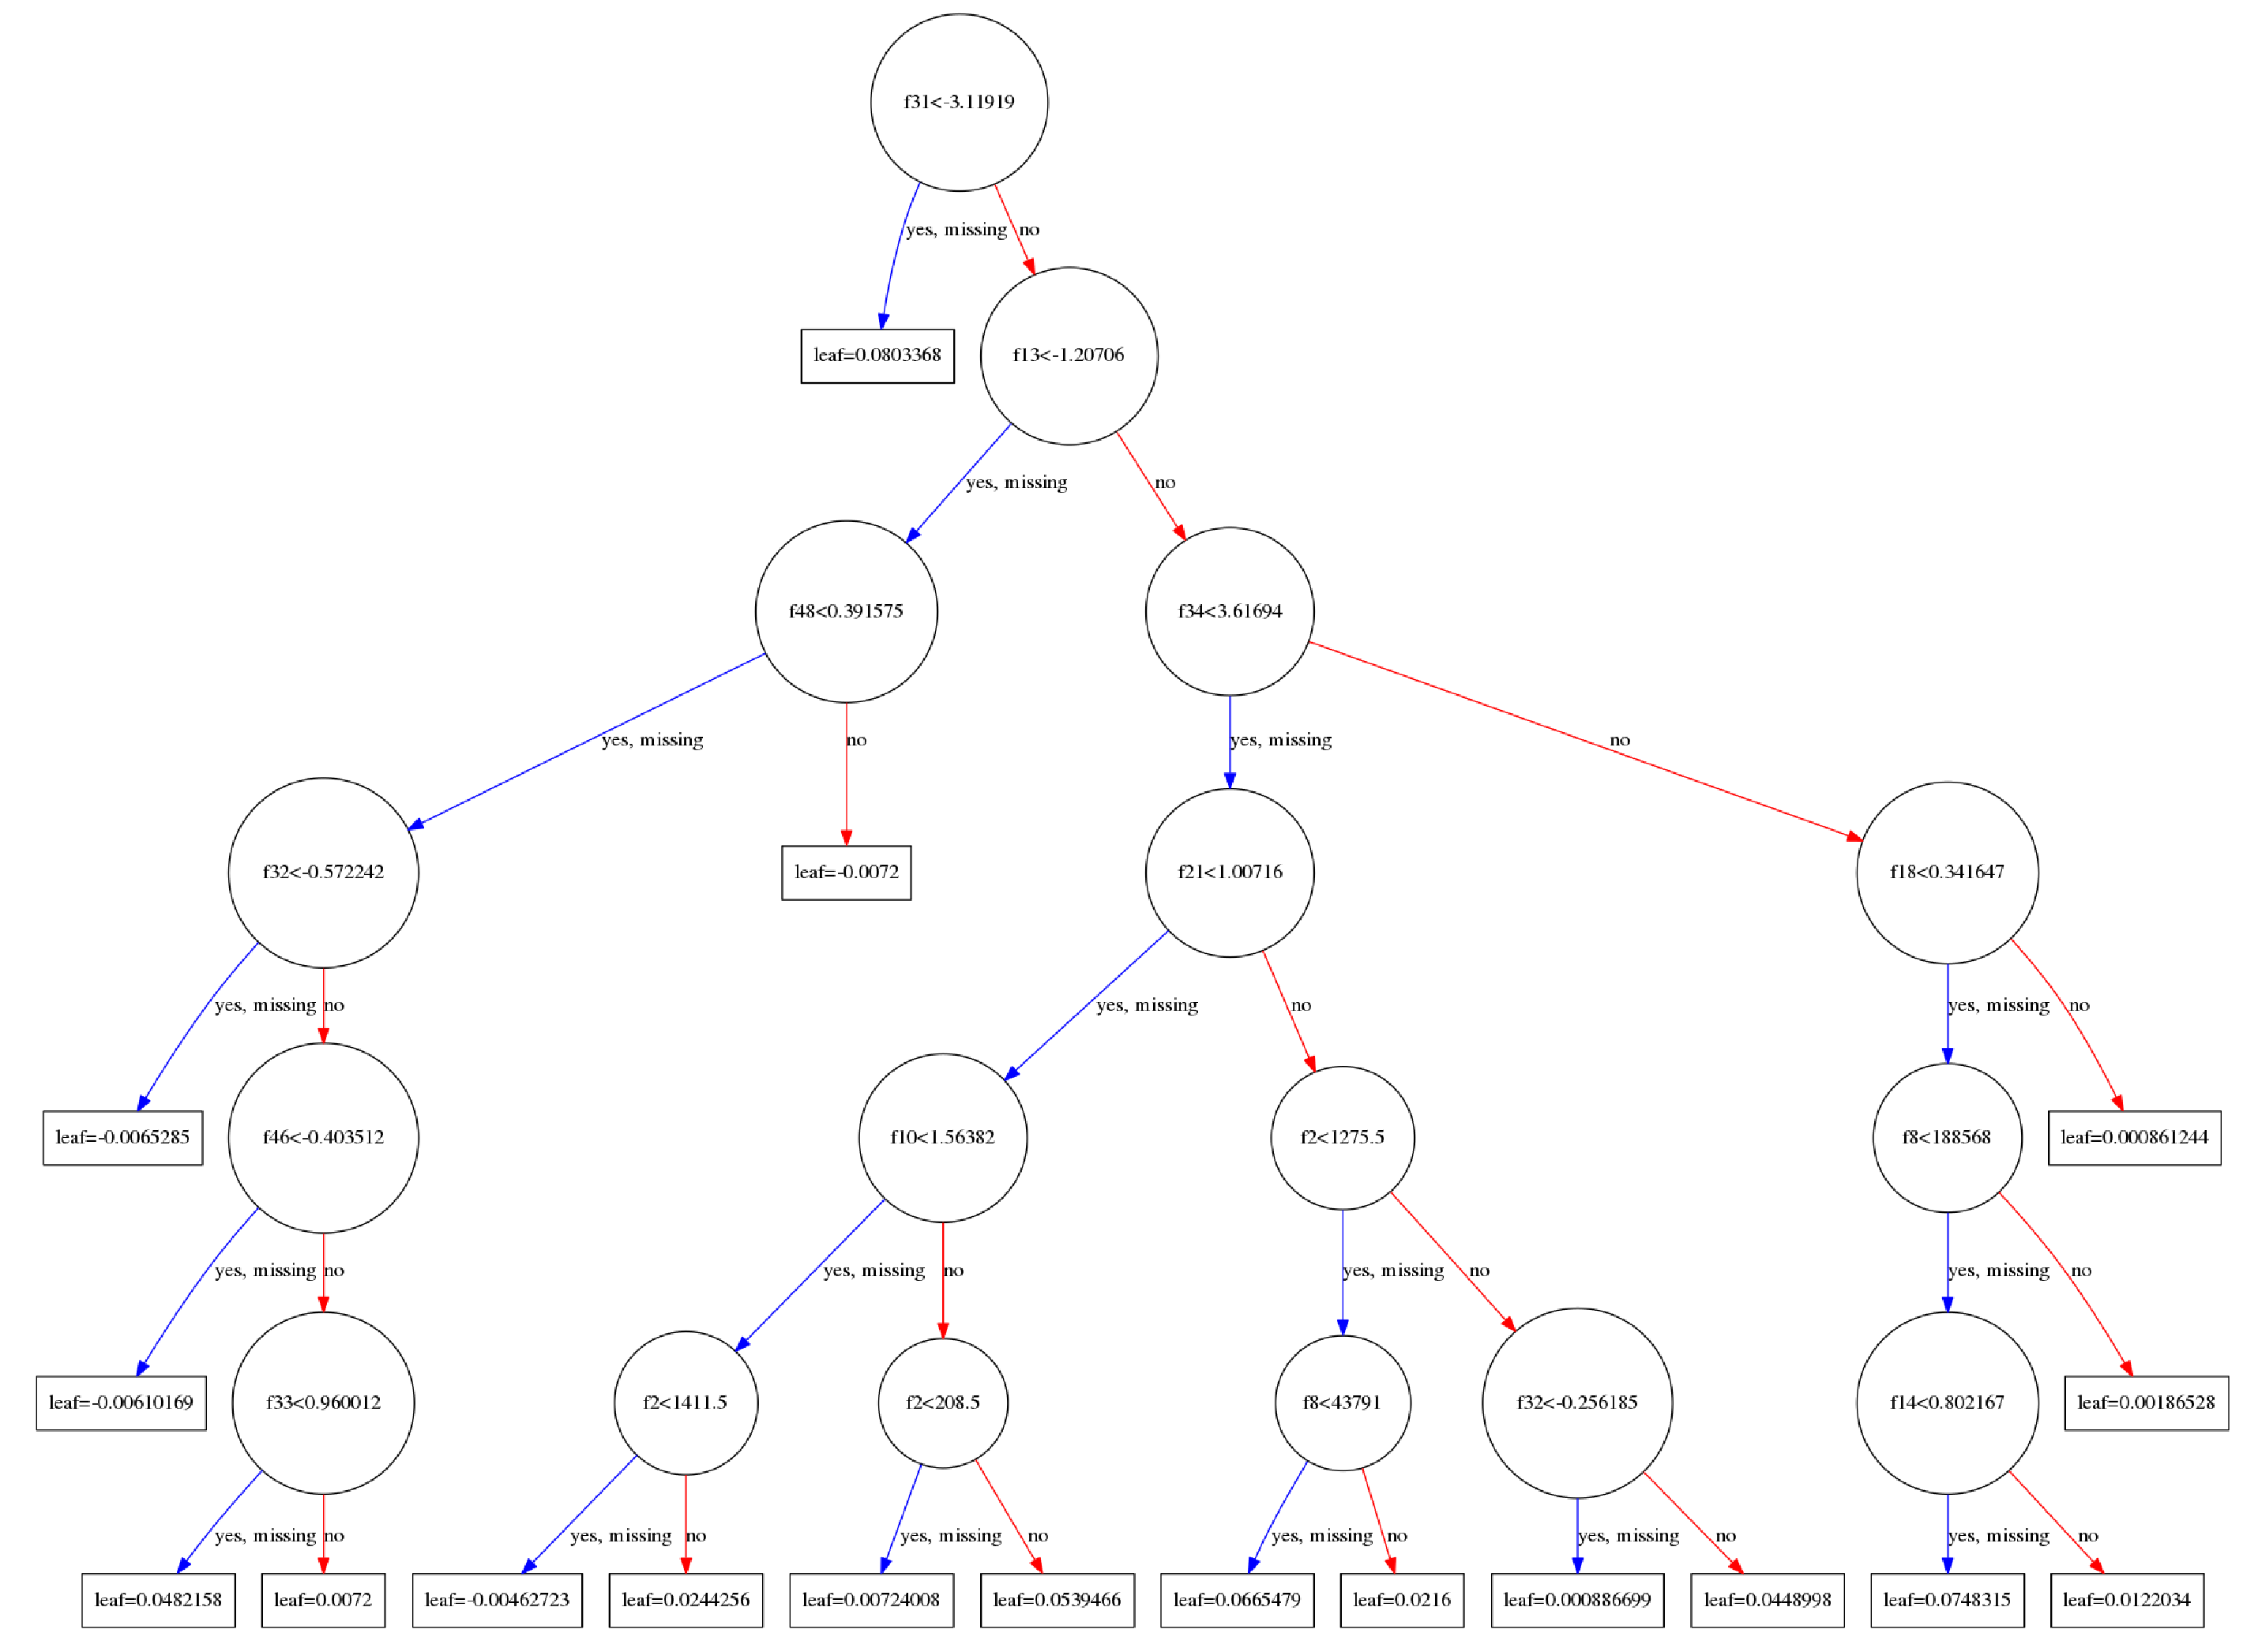

In [32]:
plt.rcParams['figure.figsize'] = (50.0, 50.0)
xgb.plot_tree(booster=model)
plt.show()

Future updates:
This script will be improved in the future using data from the following sources:
text data from

1. Encyclopedia_of_Molecular_Cell_Biology_and_Molecular_Medicine_16_volumes_Wiley_2006_
2. Cell-Molecular-Biology-Concepts-Experiments 7th edition
3. Data from http://ctdbase.org/
4. Data from the Comparative Toxicogenomics Database

Pre-trained Bio-NER taggers should be allowed in the task, which are:
* tmVar https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/tmvar/
* TaggerOne https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/taggerone/
* GNormPlus https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/gnormplus/
and we could map the variations to RSIDs and search related articles in PubMed or PMC.

6. mygene api? (http://docs.mygene.info/en/v3/doc/data.html) It contains a lot of information about genes (such as family, overall description, etc)
7. aminoacid sequences for the genes in the original dataset, in FASTA
8. allele frequency information from gnomAD or ExAC

Guiding Named Entity Recognition modles could be improved (Just for corpus for feature generation and training specific NLP tools.) by adding data from the following: ICD, SNOMED CT,NCI Thesaurus, CPT, MedDRA, SNOMED CT. 

Incorporate pretrained word2vec models from http://bio.nlplab.org/